In [1]:
import numpy as np
import pandas as pd
import time

from sklearn import preprocessing
from sklearn import linear_model
from sklearn import metrics

import matplotlib.pylab as plt
%matplotlib inline

/usr/lib64/python2.7/site-packages/sklearn/externals/joblib/_multiprocessing_helpers.py:29: UserWarning: [Errno 28] No space left on device.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


In [2]:
data_path = '/nfs/science-tuk-ins/tesco_insurance/adamho/AppliedMLTraining/data/'
train = pd.read_csv(data_path + 'regression.csv')

In [3]:
train.head()

household  retailer_dollar_sales  retailer_units  dollar_sales  units  \
0        819                   9.86               5          9.86      5   
1        875                   6.53               5          6.53      5   
2       1132                   2.78               5          2.78      5   
3       1230                  17.93               8         15.04      7   
4       2044                  10.74               6         10.74      6   

   store_satisfaction  
0            5.288486  
1            4.876407  
2            4.022451  
3            5.886475  
4            5.373975

## Excercise 3. Model Validation and Generalisation

In the slides, we saw that - if we only use the training set error for evaluation - we can cause our models to overfit. 

In this excercise, we'll show how a dataset can be split in to training and test sets. We will continue to use the regression.csv dataset from Excercise 2. 

We'll then deliberately overfit our models, so that we can see how the training & test performance changes.

Finally, we'll see how cross-validation can be performed using sklearn's handy functionality

In [4]:
X = train['units']
y = train['store_satisfaction']

##### Q1: One of the first things you should do after reading in your dataset is split it in to 3 parts; for model training, test and evaluation. Import an appropriate function from sklearn.cross_validation and split the dataset into 3 parts. For the training set, take a random 70% of the 'X' and 'y' objects; assign them to objects called 'training_X' and 'training_Y', respectively. Use half of the remaining 30% for the test and evaluation sets and assign these to test_X, text_y and eval_X, eval_y, respectively.

Hint: Some useful code is available on the slide titled 'OUT-OF-SAMPLE VALIDATION'.

In [5]:
# The answer to Q1 is...
from sklearn.cross_validation import train_test_split
training_X, testing_X, training_Y, testing_Y = train_test_split(X, y, test_size=0.3)
test_X, eval_X, test_Y, eval_Y = train_test_split(testing_X, testing_Y, test_size=0.5)

In [6]:
print 'The shapes of our objects are: training_X: {0:s}, test_X: {1:s}, eval_X: {2:s}' .format(training_X.shape, test_X.shape, eval_X.shape)

The shapes of our objects are: training_X: (1136,), test_X: (244,), eval_X: (244,)


Let's generate some polynomial features in the same way as in Excercise 2. Notice that we can use the .transform() method to apply any transformations built on the training set to our test sets. This is one of the many great features of sklearn.

In [23]:
# Use the PolynomialFeatures class in sklearn to calculate polynomial features of training_X up to degree 3
degree = 4
poly = preprocessing.PolynomialFeatures(degree=degree, include_bias=False)
training_X_poly = poly.fit_transform(training_X.reshape(-1,1))
test_X_poly = poly.transform(test_X.reshape(-1,1))
eval_X_poly = poly.transform(eval_X.reshape(-1,1))

In [24]:
# Let's fit a model to our training set, and make predictions on our training and test sets
mod = linear_model.LinearRegression()
mod.fit(training_X_poly, training_Y)
train_preds = mod.predict(training_X_poly)
test_preds = mod.predict(test_X_poly)

Let's plot the training and test set predictions to visualise how well these models fit the data

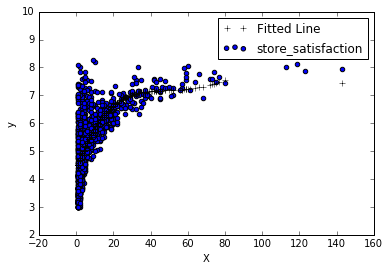

In [25]:
# The training set...
plt.scatter(training_X, training_Y)
plt.plot(training_X, train_preds, '+k',
         linewidth=3, label='Fitted Line'); # Plot a black line showing the X against the predictions
plt.legend()
plt.xlabel('X');
plt.ylabel('y');

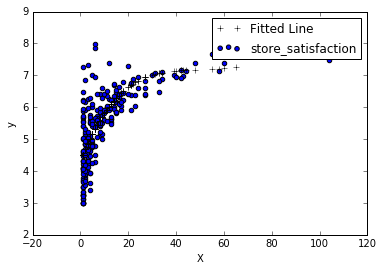

In [26]:
# The test set...
plt.scatter(test_X, test_Y)
plt.plot(test_X, test_preds, '+k',
         linewidth=3, label='Fitted Line'); # Plot a black line showing the X against the predictions
plt.legend()
plt.xlabel('X');
plt.ylabel('y');

Lets evaluate our model performance using evaluation metrics

In [27]:
# And let's calculate the r-squared and RMSE for this model
RMSE_train = np.sqrt(metrics.mean_squared_error(training_Y, train_preds))
RMSE_test = np.sqrt(metrics.mean_squared_error(test_Y, test_preds))
print('The RMSE for this model is: Train {0:.2f}, Test: {1:.2f} ') .format(RMSE_train, RMSE_test)

The RMSE for this model is: Train 0.87, Test: 0.78 


##### Q2: Go back to the block where we generate polynomial features and change degree to a different number (i.e. increase or decrease the number of polynomial features). What happens to the test set performance as you do this? How does this compare the training set performance? What value of 'degree' gives you the lowest test set performance?

In fact, we can actually plot training set and test set performance for varying degrees

In [28]:
def calculate_poly_error(degree=3):
    
    # Calculate polynomial
    poly = preprocessing.PolynomialFeatures(degree=degree, include_bias=False)
    training_X_poly = poly.fit_transform(training_X.reshape(-1,1))
    test_X_poly = poly.transform(test_X.reshape(-1,1))

    # Run the model
    mod = linear_model.LinearRegression()
    mod.fit(training_X_poly, training_Y)
    train_preds = mod.predict(training_X_poly)
    test_preds = mod.predict(test_X_poly)
    
    # Calculate the training and test error
    RMSE_train = np.sqrt(metrics.mean_squared_error(training_Y, train_preds))
    RMSE_test = np.sqrt(metrics.mean_squared_error(test_Y, test_preds))
    
    return RMSE_train, RMSE_test

In [29]:
train_errors = []
test_errors = []
degree_range = range(2,30)
for i in degree_range:
    RMSE_train, RMSE_test = calculate_poly_error(degree=i)
    train_errors.append(RMSE_train)
    test_errors.append(RMSE_test)

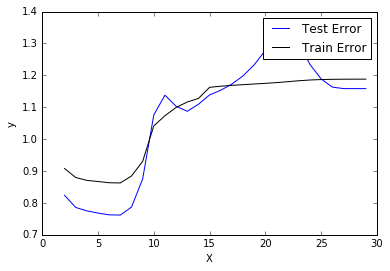

In [30]:
plt.plot(degree_range, test_errors, label='Test Error', color='blue')
plt.plot(degree_range, train_errors, label='Train Error', color='black')
plt.legend()
plt.xlabel('X');
plt.ylabel('y');

Interestingly, the training error seems to increase with the test error as the degree increases beyond 8. This is handy, as it suggests that 7/8 are **definitely** the best degrees for the problem.

Note that - as you add more polynomial terms - you add more complexity to your model. Thus, some may argue that having less polynomials is better. After all, it can get pretty hard to justify having very high order polynomials.

You must always check the test error performance to see how well your model generalises. If you check your training error, always make sure to compare this with test-error performance.

As a final check, we should now make sure that the error on the final evaluation set is similar...

In [31]:
test_preds = mod.predict(eval_X_poly)
print 'The RMSE of the final model with degree {1:d} on the final validation set is: {0:.2f}' .format(np.sqrt(metrics.mean_squared_error(training_Y, train_preds)), degree)

The RMSE of the final model with degree 4 on the final validation set is: 0.87


## 3.2: Cross Validation 

We've checked how our model performs on the test set lots of times now. In fact, in the last excercise we checked models against the test set 28 times. 

If we keep checking our model against the test set, we can start overfitting towards the test set. 

As machine learning practitioners, we are going to be fitting lots of models and making a lot of decisions based on the test set performance. In order to be sure that we're not over-fitting towards the test set, we need to perform cross-validation.

Luckily, sklearn has a couple of great functions built in to help you perform cross-validation.

In [249]:
# The easiest way to perform cross validation is with sklearn's cross_val_score...
folds = 7

from sklearn.cross_validation import cross_val_score
mod = linear_model.LinearRegression()
start = time.time()
scores = cross_val_score(mod, training_X_poly, training_Y, cv=folds, scoring='mean_squared_error') # Perform 5-fold cross validation
end = time.time()
mean_cv = np.mean(np.sqrt(abs(scores)))

print 'The mean {2:d} fold cross-validation performance of a model with degree {1:d} is: {0:.3f}' .format(mean_cv, degree, folds)
print('The cross_val_score function took {0:.2f} seconds to run') .format(end - start)

The mean 7 fold cross-validation performance of a model with degree 15 is: 449.692
The cross_val_score function took 0.03 seconds to run


##### Q3. Go back to the block above and change the value of 'folds'. How does increasing/decreasing the number of folds affect the time taken to run the cross_val_score function? What happens to the mean cross-validation performance (on average) as you increase/decrease the number of folds? Can you explain why?

If you need to scale, reduce the dimensionality or perform any other transformations to your data, you will need to perform them on your training set and then check them using your validation performance. Thus, for cross-validation you will need to perform these transformations in between folds of cross-validation. 

The cross_val_score function does not allow you to perform transformations between folds. For this, you can sklearn's iterator function KFold. This will supply you with indices that enable you to separate out the training and validation parts of each fold. Here's an example...

In [214]:
# Define the kind of cross-validation that we want to do using the KFold function
from sklearn.cross_validation import KFold
folds = 5
kf = KFold(n=training_X_poly.shape[0], n_folds=folds, shuffle=False,
                random_state=32) # Setting a random_state ensures that the folds will contain the same rows when run on separate occasions 

# Define the scaler that you want to use
scl = preprocessing.MinMaxScaler()

# Initialise some variables to record the performance
cv_perf = []

# Perform cross-validation 
for train_index, test_index in kf:
    
    # Subset out the training and validation folds
    X_train_cv, X_test_cv = training_X_poly[train_index], training_X_poly[test_index]
    y_train_cv, y_test_cv = training_Y.values[train_index], training_Y.values[test_index]
    
    # Fit the scaler to the training set and apply it to the test set
    X_train_cv = scl.fit_transform(X_train_cv)
    X_test_cv = scl.transform(X_test_cv)
    
    # Fit the model and make predictions
    mod = linear_model.LinearRegression()
    mod.fit(X_train_cv, y_train_cv)
    cv_preds = mod.predict(X_test_cv)
    
    # Calculate the RMSE
    cv_rmse = np.sqrt(metrics.mean_squared_error(y_test_cv, cv_preds))
    cv_perf.append(cv_rmse)
    
# Print the average performance to the screen
print 'The mean {2:d} fold cross-validation performance of a model with degree {1:d} is: {0:.3f}' .format(np.mean(cv_perf), degree, folds)

The mean 5 fold cross-validation performance of a model with degree 3 is: 0.852


Note that the cross-validation performance is exactly the same as before. Thus, scaling is arguably not necessary in this case.

Don't worry too much if you can't understand all of that code right now. The first thing is to trust that it is performing cross-validation and that it is scaling the training and test data between folds.

When applying transformations to your data - unless you can prove that they are the right thing to do regardless - you should check whether they improve your model performance by performing them in between cross-validation folds and checking whether the average performance on your evaluation metric has improved.

...At least, that's the theory. In reality, things can slow down quite a bit if you apply transformations between folds. Thus, you may be able to get away with applying transformations to the whole data (e.g. scaling everything first > then performing CV). It's up to you to decide how thorough you need to be!